In [1]:
import pandas as pd
from pandas import DataFrame as dframe
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import choice
from numpy import array as arr

import jax as j
cpu = j.devices("cpu")[0]
from jax import random, vmap
import jax.numpy as jnp
import numpyro
from numpyro.distributions import *
from numpyro import sample, plate, param, deterministic
from numpyro.optim import Adam, Minimize
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import SVI, Trace_ELBO, init_to_value, Predictive

import utils
from utils import *
from utils.data import *
from utils.analysis import * # precis, cov2cor
from utils.stats import * 
from utils.plots import *
utils.init() # init plotting styles and hush warnings
seed = random.PRNGKey(1776)

# Lecture 5 Elemental Confounds

## The Fork

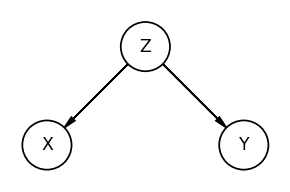

In [2]:
dag = init_dag()
dag.add_node("Z", "Z", 0, 0)
dag.add_node("X", "X", -1, -1)
dag.add_node("Y", "Y", 1, -1)
dag.add_edge("Z", "X")
dag.add_edge("Z", "Y")
dag.show()

In [3]:
seed, _ = random.split(seed)
N = 300
Z = Bernoulli(.5).sample(seed, (N,))
X = Normal(2*Z - 1, 1).sample(seed//2)
Y = Normal(2*Z - 1, 1).sample(seed//3)

In [4]:
np.corrcoef(X, Y).round(2)

array([[1.  , 0.48],
       [0.48, 1.  ]])

In [5]:
np.corrcoef(X[Z == 0], Y[Z == 0]).round(2)

array([[ 1.  , -0.01],
       [-0.01,  1.  ]])

In [6]:
np.corrcoef(X[Z == 1], Y[Z == 1]).round(2)

array([[ 1.  , -0.07],
       [-0.07,  1.  ]])

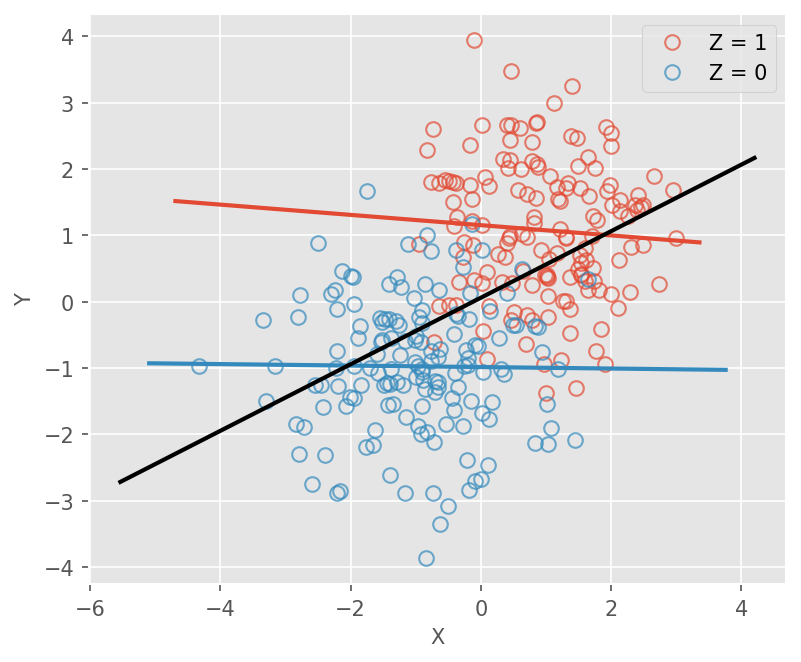

In [7]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(X[Z == 1], Y[Z == 1], c="C0", label="Z = 1")
scatter(X[Z == 0], Y[Z == 0], c="C1", label="Z = 0")

abline_lm(X[Z == 1], Y[Z == 1], ax, c="C0", lw=2)
abline_lm(X[Z == 0], Y[Z == 0], ax, c="C1", lw=2)
abline_lm(X, Y, ax, lw=2)
ax.set(xlabel="X", ylabel="Y")
ax.legend();

### Fork example 

In the WaffleDivorce data, is it true that M -> D?

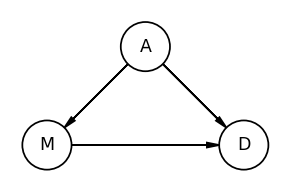

In [8]:
dag_div = init_dag()
dag_div.add_node("A", "A", 1, 1)
dag_div.add_node("M", "M", 0, 0)
dag_div.add_node("D", "D", 2, 0)
dag_div.add_edge("A", "M")
dag_div.add_edge("A", "D")
dag_div.add_edge("M", "D")
dag_div.show()

In [9]:
d = data("WaffleDivorce")

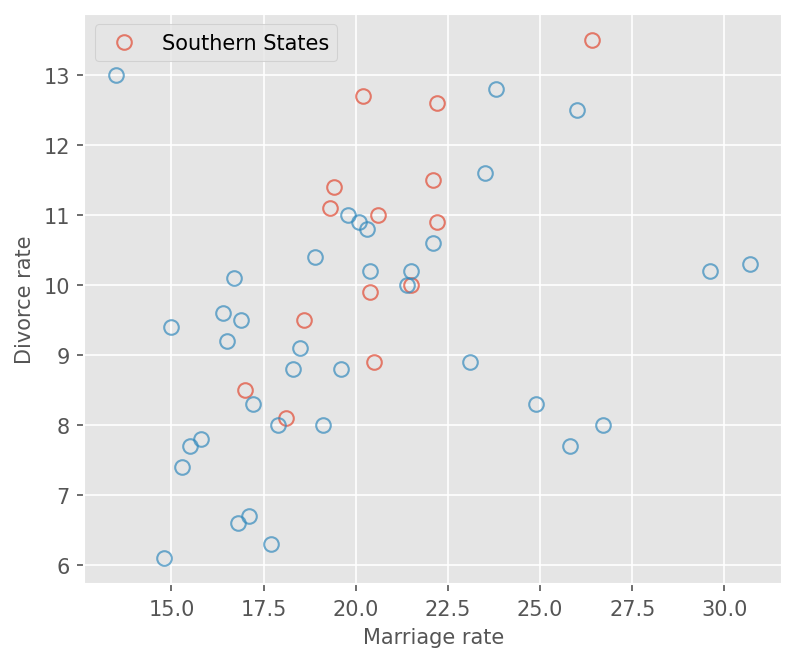

In [10]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(d[d.South.astype(bool)].Marriage, d[d.South.astype(bool)].Divorce, 
        c="C0", label="Southern States")
scatter(d[~d.South.astype(bool)].Marriage, d[~d.South.astype(bool)].Divorce,
        c="C1")
ax.set(xlabel="Marriage rate", ylabel="Divorce rate")
ax.legend();

A -> D?

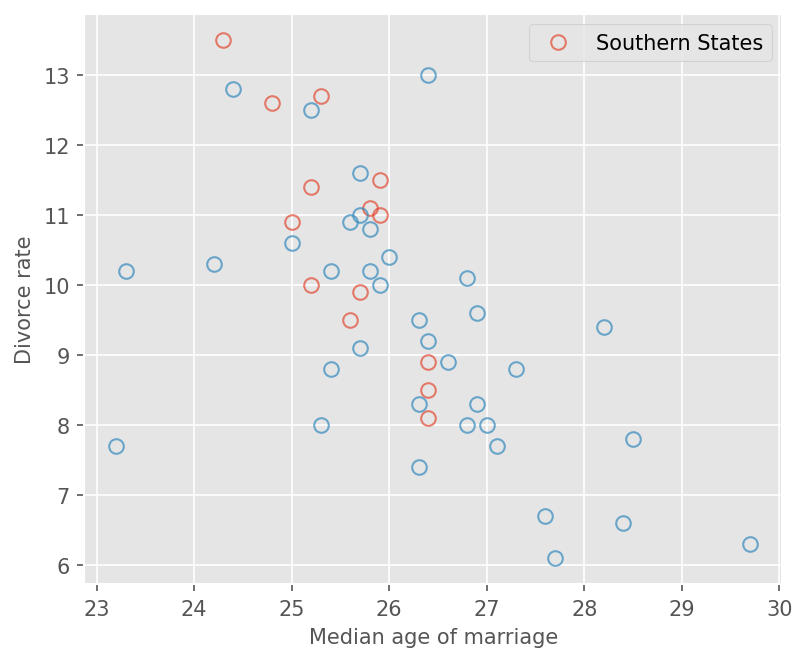

In [11]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(d[d.South.astype(bool)].MedianAgeMarriage, d[d.South.astype(bool)].Divorce, 
        c="C0", label="Southern States")
scatter(d[~d.South.astype(bool)].MedianAgeMarriage, d[~d.South.astype(bool)].Divorce,
        c="C1")
ax.set(xlabel="Median age of marriage", ylabel="Divorce rate")
ax.legend();

A -> M is quite intuitive. 

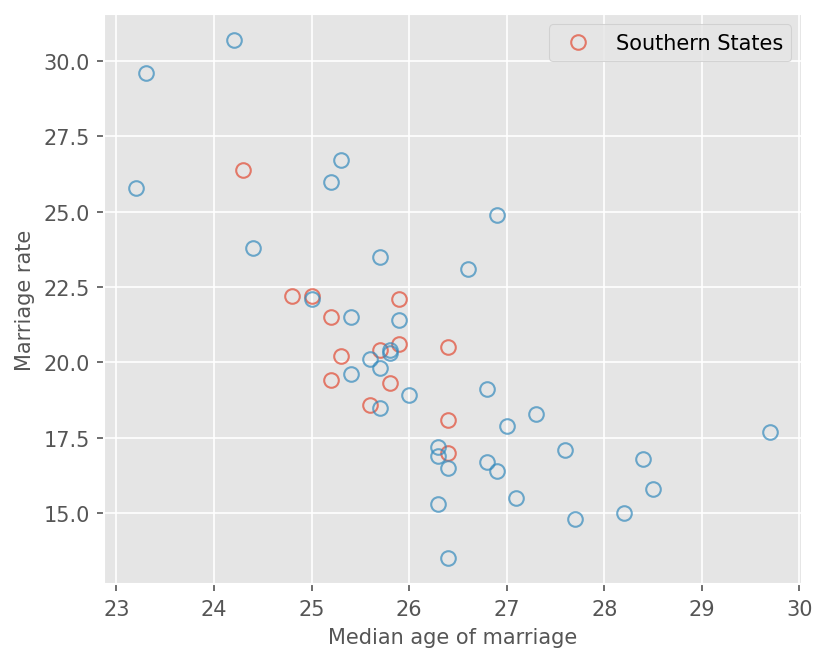

In [12]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(d[d.South.astype(bool)].MedianAgeMarriage, d[d.South.astype(bool)].Marriage, 
        c="C0", label="Southern States")
scatter(d[~d.South.astype(bool)].MedianAgeMarriage, d[~d.South.astype(bool)].Marriage,
        c="C1")
ax.set(xlabel="Median age of marriage", ylabel="Marriage rate")
ax.legend();

Fork: M <- A -> D (take this as granted). So if we want to estimate M -> D, then stratify by A.

How to stratify by a continous variable? Express D as a function of A and M.

Simplest way: `D ~ A + M`. Here we have a different intercept value for each individual: $\alpha + \beta_A A_i$, that's how we stratify by this continuous A.

Every value of A possibly produces a different relationship between D and M.

### Model

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_M M_i + \beta_A A_i$$
$$\alpha \sim \text{Normal}(?, ?)$$
$$\beta_M \sim \text{Normal}(?, ?)$$
$$\beta_A \sim \text{Normal}(?, ?)$$
$$\sigma \sim \text{Exponential}(?)$$

### Prior predictive simulation

Let's impose some flat priors on the parameters.

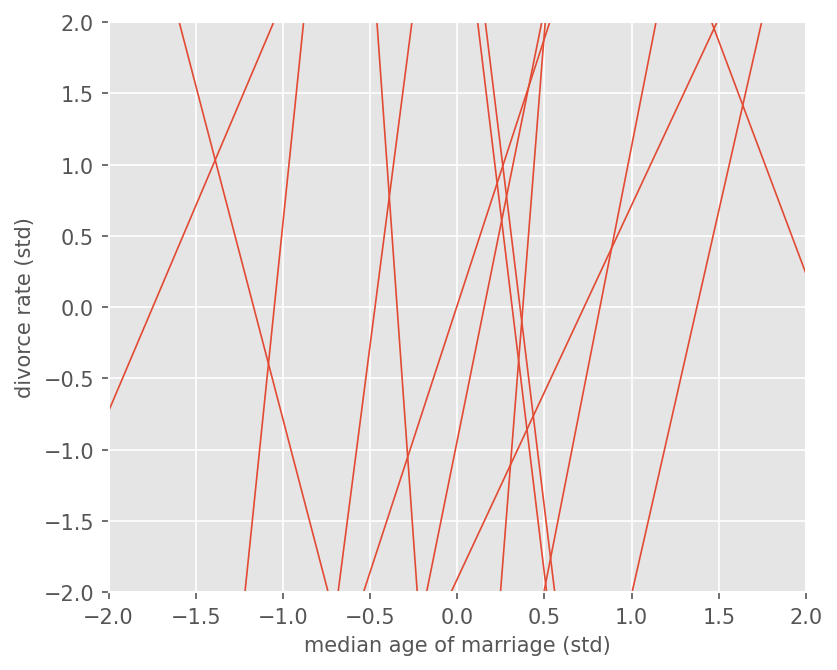

In [13]:
n = 20
seed, _ = random.split(seed)
a = Normal(0, 10).sample(seed//5, (n,))
bM = Normal(0, 10).sample(seed//7, (n,))
bA = Normal(0, 10).sample(seed//11, (n,)) 

_, ax = plt.subplots(figsize=(6, 4))
ax.set(xlim=[-2, 2], ylim=[-2, 2], 
       xlabel="median age of marriage (std)",
       ylabel="divorce rate (std)")
Aseq = np.linspace(-3, 3, 30)
for i in range(n):
    mu = a[i] + bA[i]*Aseq
    ax.plot(Aseq, mu, color="C0")

Better priors

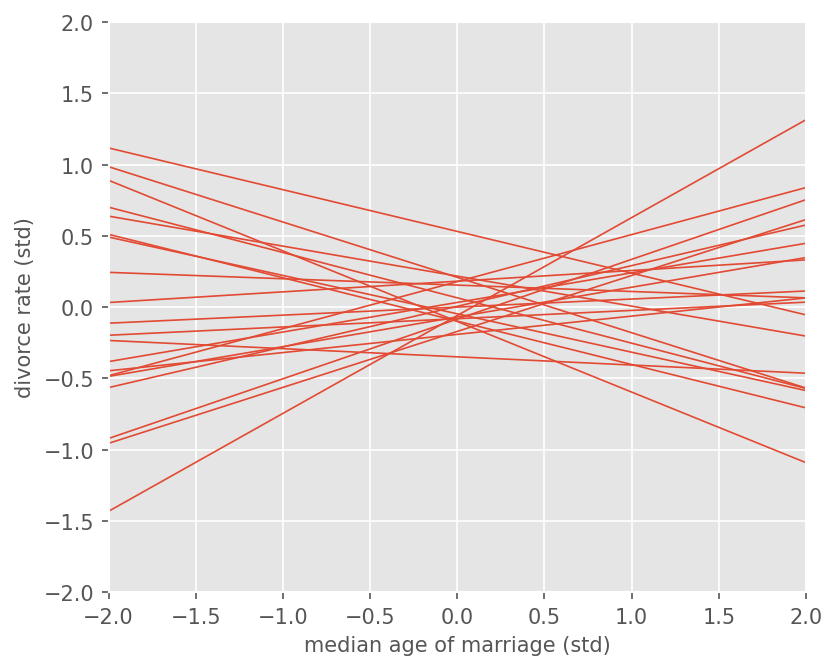

In [14]:
n = 20
seed, _ = random.split(seed)
a = Normal(0, .2).sample(seed//5, (n,))
bM = Normal(0, .5).sample(seed//7, (n,))
bA = Normal(0, .5).sample(seed//11, (n,)) 

_, ax = plt.subplots(figsize=(6, 4))
ax.set(xlim=[-2, 2], ylim=[-2, 2], 
       xlabel="median age of marriage (std)",
       ylabel="divorce rate (std)")
Aseq = np.linspace(-3, 3, 30)
for i in range(n):
    mu = a[i] + bA[i]*Aseq
    ax.plot(Aseq, mu, color="C0")

### Analyze with the data

In [15]:
dat = dict(D=scale(d.Divorce.values),
           M=scale(d.Marriage.values),
           A=scale(d.MedianAgeMarriage.values)
          )


def f_DMA(A, M, D=None):
    a = sample("a", Normal(0, .2))
    bM = sample("bM", Normal(0, .5))
    bA = sample("bA", Normal(0, .5))
    sigma = sample("sigma", Exponential(1))
    mu = deterministic("mu", a + bM*M + bA*A)
    sample("D", Normal(mu, sigma), obs=D)
    

m_DMA = AutoLaplaceApproximation(f_DMA)
p_DMA = (SVI(f_DMA, m_DMA, Adam(1), Trace_ELBO())
            .run(seed, 2000, **dat).params)

100%|████████████████████████| 2000/2000 [00:00<00:00, 2051.46it/s, init loss: 497.8806, avg. loss [1901-2000]: 61.2910]


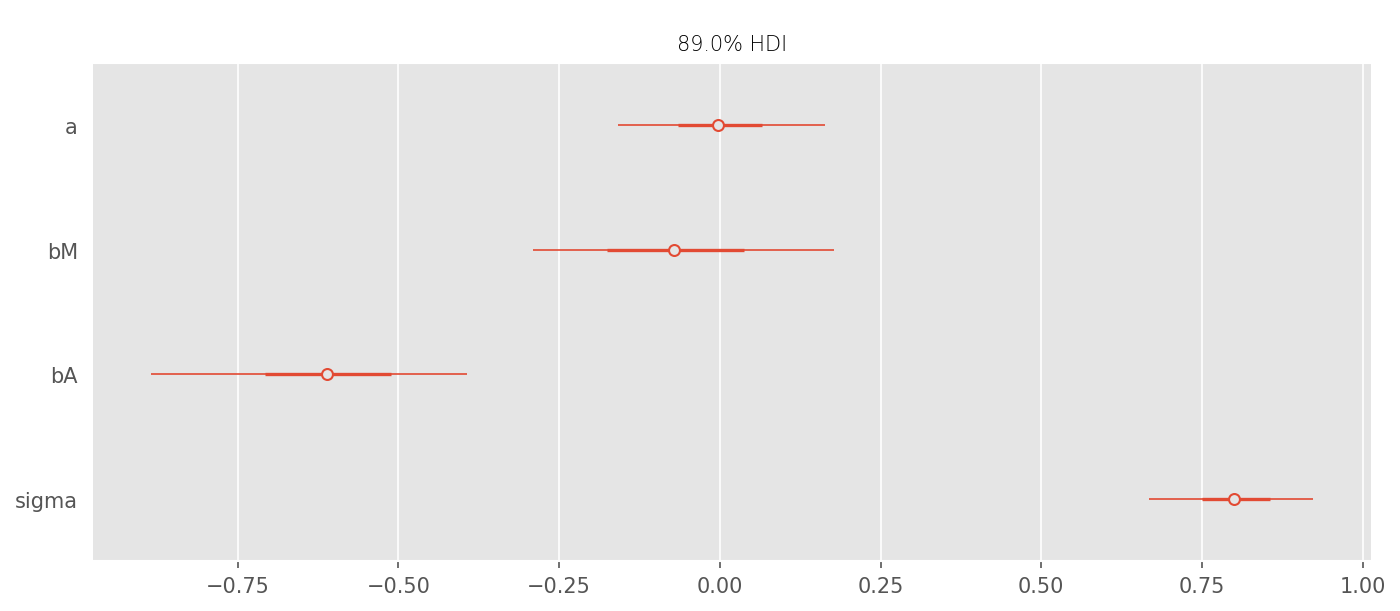

In [16]:
post_DMA = m_DMA.sample_posterior(seed, p_DMA, (1, 1000))
_, ax = plt.subplots()
az.plot_forest(post_DMA, var_names=["a", "bM", "bA", "sigma"], ax=ax);

What's the causal effect of M on D?

Usually we report the value of the slope. But generally not legit.

We should report $p(D|do(M))$ by simulation from the learned model.

### Simulating interventions

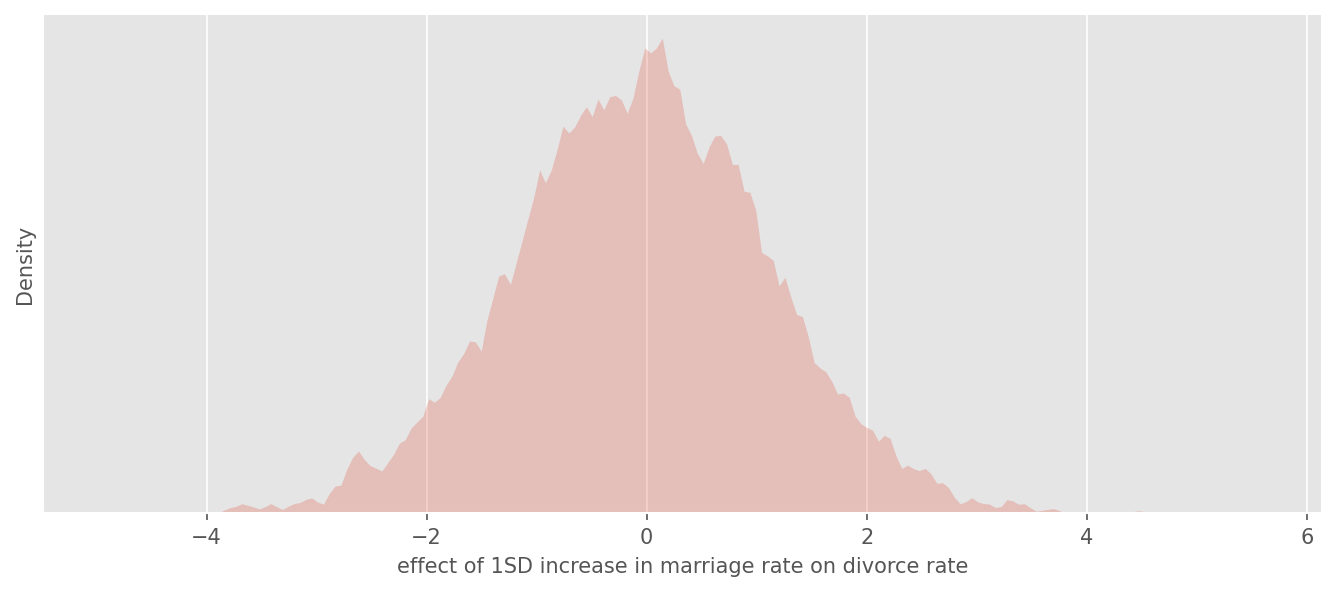

In [17]:
n = 100
post_DMA = m_DMA.sample_posterior(seed, p_DMA, (n,))

# sample A from the data
As = choice(dat["A"], n, replace=True)

# simulate D for M=0 (M at sample mean)
DM0 = Predictive(f_DMA, post_DMA, return_sites=["D"]) \
                (seed, A=As, M=0)["D"].flatten()

# simulate D for M=1 (M at +1 sample SD)
seed, _ = random.split(seed)
DM1 = Predictive(f_DMA, post_DMA, return_sites=["D"]) \
                (seed, A=As, M=1)["D"].flatten()

# contrast 
M10_contrast = DM1 - DM0
ax = plt.subplot()
dens(M10_contrast, bw_adjust=.2)
ax.set(xlabel="effect of 1SD increase in marriage rate on divorce rate",
       yticks=[]);

Can't say there's no M -> D effect because the variability in the contrasts is large, even if they are centered at zero.

## The Pipe

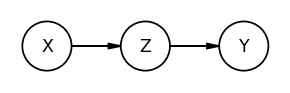

In [18]:
dag = init_dag()
dag.add_node("Z", "Z", 0, 0)
dag.add_node("X", "X", -1, 0)
dag.add_node("Y", "Y", 1, 0)
dag.add_edge("X", "Z")
dag.add_edge("Z", "Y")
dag.show()

In [19]:
n = 1000
X = Bernoulli(.5).sample(seed, (n,))
Z = Bernoulli((1 - X)*0.1 + X*0.9).sample(seed//101)
Y = Bernoulli((1 - Z)*0.1 + Z*0.9).sample(seed//137)

In [20]:
np.corrcoef(X, Y).round(2)

array([[1.  , 0.64],
       [0.64, 1.  ]])

In [21]:
np.corrcoef(X[Z == 0], Y[Z == 0]).round(2)

array([[ 1.  , -0.04],
       [-0.04,  1.  ]])

In [22]:
np.corrcoef(X[Z == 1], Y[Z == 1]).round(2)

array([[1.  , 0.02],
       [0.02, 1.  ]])

In [23]:
seed, _ = random.split(seed)
N = 300
X = Normal().sample(seed, (N,))
Z = Bernoulli(logits=X).sample(seed//29)
Y = Normal(2*Z - 1).sample(seed//47)

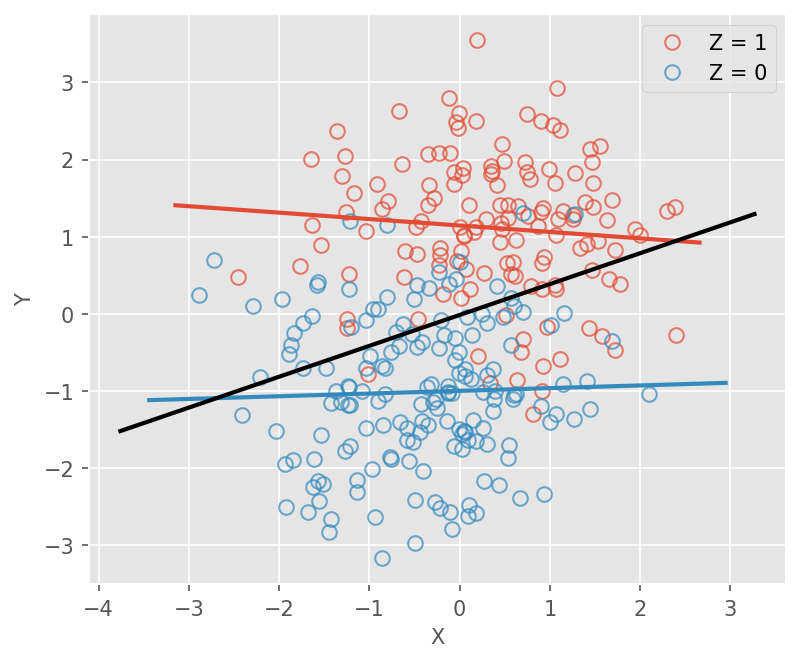

In [24]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(X[Z == 1], Y[Z == 1], c="C0", label="Z = 1")
scatter(X[Z == 0], Y[Z == 0], c="C1", label="Z = 0")
abline_lm(X[Z == 1], Y[Z == 1], ax=ax, c="C0", lw=2)
abline_lm(X[Z == 0], Y[Z == 0], ax=ax, c="C1", lw=2)
abline_lm(X, Y, ax=ax, c="k", lw=2)
ax.set(xlabel="X", ylabel="Y")
ax.legend();

### Pipe example

100 plants, (RCT experiment) half treated with anti-fungal, measure fungus and growth.

Estimand: causal effect of treatment on plant growth.

_Q: does RCT save you from doing causal inference?_

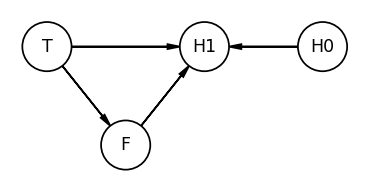

In [25]:
dag_plant = init_dag()
dag_plant.add_node("F", "F", 0, 0)
dag_plant.add_node("H1", "H1", .8, 1)
dag_plant.add_node("H0", "H0", 2, 1)
dag_plant.add_node("T", "T", -.8, 1)
dag_plant.add_edge("T", "F")
dag_plant.add_edge("T", "H1")
dag_plant.add_edge("F", "H1")
dag_plant.add_edge("H0", "H1")
dag_plant.show()

Estimand: total causal effect of T on H1. Should we stratify by F? No.

If stratifying the fungus intensity F, you would remove the upsides of the treatment.

In a linear regression model with H1 as the response, this means you should not include F as one of the covariates, if your goal is to interpret the slope of T.

Stratifying by F induces **post-treatment bias**, might mislead that treatment does/doesn't work. _Doing RCT is no protection against bad causal inference_.

-
Another example of post-treatment bias, but this time misleading us to think that the treatment works:

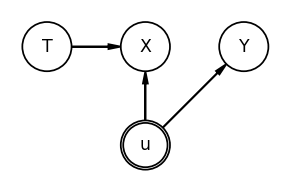

In [26]:
dagg = init_dag()
dagg.add_node("T", "T", -1, 1)
dagg.add_node("X", "X", 0, 1)
dagg.add_node("u", "u", observed=True)
dagg.add_node("Y", "Y", 1, 1)
dagg.add_edge("T", "X")
dagg.add_edge("u", "X")
dagg.add_edge("u", "Y")
dagg.show()

## The Collider

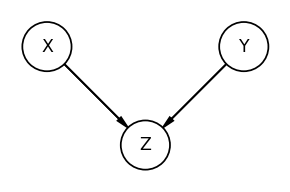

In [27]:
dag = init_dag()
dag.add_node("Z", "Z", 0, 0)
dag.add_node("X", "X", -1, 1)
dag.add_node("Y", "Y", 1, 1)
dag.add_edge("X", "Z")
dag.add_edge("Y", "Z")
dag.show()

In [28]:
n = 1000
seed, _ = random.split(seed)
X = Bernoulli(.5).sample(seed, (n,))
Y = Bernoulli(.5).sample(seed//37, (n,))
Z = Bernoulli(np.where(X + Y > 0, 0.9, 0.2)).sample(seed//59)

In [29]:
np.corrcoef(X, Y).round(2)

array([[1.  , 0.03],
       [0.03, 1.  ]])

In [30]:
np.corrcoef(X[Z == 0], Y[Z == 0]).round(2)

array([[1.  , 0.45],
       [0.45, 1.  ]])

In [31]:
np.corrcoef(X[Z == 1], Y[Z == 1]).round(2)

array([[ 1.  , -0.26],
       [-0.26,  1.  ]])

In [32]:
n = 300
seed, _ = random.split(seed)
X = Normal().sample(seed, (n,))
seed, _ = random.split(seed)
Y = Normal().sample(seed, (n,))
seed, _ = random.split(seed)
Z = Bernoulli(logits=2*X + 2*Y - 2).sample(seed)

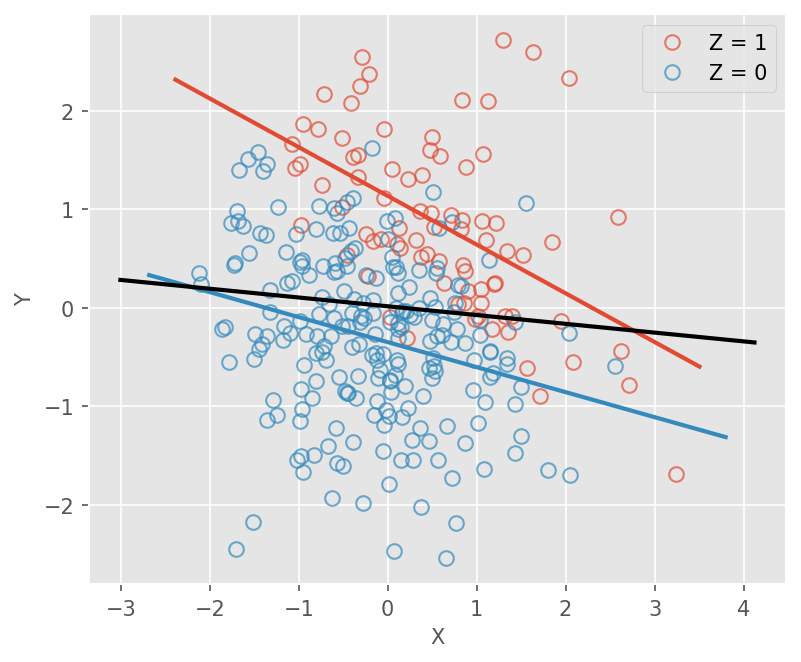

In [33]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(X[Z == 1], Y[Z == 1], c="C0", label="Z = 1")
scatter(X[Z == 0], Y[Z == 0], c="C1", label="Z = 0")
abline_lm(X[Z == 1], Y[Z == 1], ax=ax, c="C0", lw=2)
abline_lm(X[Z == 0], Y[Z == 0], ax=ax, c="C1", lw=2)
abline_lm(X, Y, ax=ax, c="k", lw=2)
ax.set(xlabel="X", ylabel="Y")
ax.legend();

### Collider examples

**Selection bias/survivorship bias**

- Academic grant applications (hype, quality, outcome -> grants)
- Restaurants (food, location, outcome -> survives)
- Guys in the dating market (cute, great personality, outcome -> still single)

## The Descendant

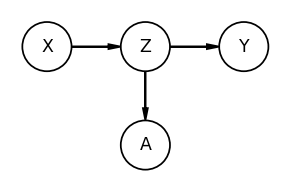

In [34]:
dag = init_dag()
dag.add_node("X", "X", -1, 0)
dag.add_node("Z", "Z", 0, 0)
dag.add_node("Y", "Y", 1, 0)
dag.add_node("A", "A", 0, -1)
dag.add_edge("X", "Z")
dag.add_edge("Z", "A")
dag.add_edge("Z", "Y")
dag.show()

In [35]:
n = 1000
seed, _ = random.split(seed)
X = Bernoulli(.5).sample(seed, (n,))
seed, _ = random.split(seed)
Z = Bernoulli((1 - X)*.1 + X*.9).sample(seed)
seed, _ = random.split(seed)
Y = Bernoulli((1 - Z)*.1 + Z*.9).sample(seed)
seed, _ = random.split(seed)
A = Bernoulli((1 - Z)*.1 + Z*.9).sample(seed)

In [36]:
np.corrcoef(X, Y).round(2)

array([[1.  , 0.64],
       [0.64, 1.  ]])

In [37]:
np.corrcoef(X[A == 0], Y[A == 0]).round(2)

array([[1. , 0.4],
       [0.4, 1. ]])

In [38]:
np.corrcoef(X[A == 1], Y[A == 1]).round(2)

array([[1.  , 0.29],
       [0.29, 1.  ]])

**Descendants are everywhere.** Many measuremants are descandants of what we want to measure. (Factor analysis, social networks..)

## Watermark

In [39]:
%reload_ext watermark
%watermark -v -iv -u -dt

Last updated: 2023-05-09 22:07:31

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.12.0

numpyro   : 0.11.0
seaborn   : 0.12.2
jax       : 0.4.8
numpy     : 1.24.3
pandas    : 2.0.0
matplotlib: 3.7.1
xarray    : 2023.4.2
arviz     : 0.15.1

